<a href="https://colab.research.google.com/github/xiexiao6/nut/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 准备

In [ ]:
import time
import os
from tqdm import tqdm

import pandas as pd
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")

# 获取计算硬件
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


In [ ]:
from torchvision import transforms

# 训练集图像预处理：缩放裁剪、图像增强、转 Tensor、归一化
train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
                                    ])

In [ ]:
# 数据集文件夹路径
dataset_dir = '/content/drive/MyDrive/new_data'
train_path = dataset_dir
test_path = dataset_dir
print('训练集路径', train_path)
print('测试集路径', test_path)

from torchvision import datasets
# 载入训练集
train_dataset = datasets.ImageFolder(train_path, train_transform)
# 载入测试集
test_dataset = datasets.ImageFolder(test_path, test_transform)

print('训练集图像数量', len(train_dataset))
print('类别个数', len(train_dataset.classes))
print('各类别名称', train_dataset.classes)
print('测试集图像数量', len(test_dataset))
print('类别个数', len(test_dataset.classes))
print('各类别名称', test_dataset.classes)

训练集路径 /content/drive/MyDrive/new_data
测试集路径 /content/drive/MyDrive/new_data
训练集图像数量 1106
类别个数 10
各类别名称 ['BarrelNut', 'EccentricNuts', 'FlangNut', 'HornNuts', 'M3Nut', 'M4Nut', 'M5Nut', 'M6Nut', 'M8Nut', 'SlottedNut']
测试集图像数量 1106
类别个数 10
各类别名称 ['BarrelNut', 'EccentricNuts', 'FlangNut', 'HornNuts', 'M3Nut', 'M4Nut', 'M5Nut', 'M6Nut', 'M8Nut', 'SlottedNut']
训练集路径 /content/drive/MyDrive/new_data
测试集路径 /content/drive/MyDrive/new_data
训练集图像数量 1106
类别个数 10
各类别名称 ['BarrelNut', 'EccentricNuts', 'FlangNut', 'HornNuts', 'M3Nut', 'M4Nut', 'M5Nut', 'M6Nut', 'M8Nut', 'SlottedNut']
测试集图像数量 1106
类别个数 10
各类别名称 ['BarrelNut', 'EccentricNuts', 'FlangNut', 'HornNuts', 'M3Nut', 'M4Nut', 'M5Nut', 'M6Nut', 'M8Nut', 'SlottedNut']


In [ ]:
# 各类别名称
class_names = train_dataset.classes
n_class = len(class_names)
# 映射关系：类别 到 索引号
train_dataset.class_to_idx
# 映射关系：索引号 到 类别
idx_to_labels = {y:x for x,y in train_dataset.class_to_idx.items()}
# 保存为本地的 npy 文件
np.save('idx_to_labels.npy', idx_to_labels)
np.save('labels_to_idx.npy', train_dataset.class_to_idx)

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# 训练集的数据加载器
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4
                         )

# 测试集的数据加载器
test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4
                        )

In [ ]:
from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler

In [ ]:
model = models.resnet18(pretrained=False) # 只载入模型结构，不载入预训练权重参数

model.fc = nn.Linear(model.fc.in_features, n_class)

optimizer = optim.Adam(model.parameters())
model = model.to(device)

# 交叉熵损失函数
criterion = nn.CrossEntropyLoss()

# 训练轮次 Epoch
EPOCHS = 10

# 学习率降低策略
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

def train_one_batch(images, labels):
    '''
    运行一个 batch 的训练，返回当前 batch 的训练日志
    '''

    # 获得一个 batch 的数据和标注
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images) # 输入模型，执行前向预测
    loss = criterion(outputs, labels) # 计算当前 batch 中，每个样本的平均交叉熵损失函数值

    # 优化更新权重
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 获取当前 batch 的标签类别和预测类别
    _, preds = torch.max(outputs, 1) # 获得当前 batch 所有图像的预测类别
    preds = preds.cpu().numpy()
    loss = loss.detach().cpu().numpy()
    outputs = outputs.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    log_train = {}
    log_train['epoch'] = epoch
    log_train['batch'] = batch_idx
    # 计算分类评估指标
    log_train['train_loss'] = loss
    log_train['train_accuracy'] = accuracy_score(labels, preds)
    log_train['train_precision'] = precision_score(labels, preds, average='macro')
    log_train['train_recall'] = recall_score(labels, preds, average='macro')
    log_train['train_f1-score'] = f1_score(labels, preds, average='macro')

    return log_train

In [ ]:
def evaluate_testset():
    '''
    在整个测试集上评估，返回分类评估指标日志
    '''

    loss_list = []
    labels_list = []
    preds_list = []

    with torch.no_grad():
        for images, labels in test_loader: # 生成一个 batch 的数据和标注
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images) # 输入模型，执行前向预测

            # 获取整个测试集的标签类别和预测类别
            _, preds = torch.max(outputs, 1) # 获得当前 batch 所有图像的预测类别
            preds = preds.cpu().numpy()
            loss = criterion(outputs, labels) # 由 logit，计算当前 batch 中，每个样本的平均交叉熵损失函数值
            loss = loss.detach().cpu().numpy()
            outputs = outputs.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()

            loss_list.append(loss)
            labels_list.extend(labels)
            preds_list.extend(preds)

    log_test = {}
    log_test['epoch'] = epoch

    # 计算分类评估指标
    log_test['test_loss'] = np.mean(loss_list)
    log_test['test_accuracy'] = accuracy_score(labels_list, preds_list)
    log_test['test_precision'] = precision_score(labels_list, preds_list, average='macro')
    log_test['test_recall'] = recall_score(labels_list, preds_list, average='macro')
    log_test['test_f1-score'] = f1_score(labels_list, preds_list, average='macro')

    return log_test

In [ ]:
epoch = 0
batch_idx = 0
best_test_accuracy = 0
# 训练日志-训练集
df_train_log = pd.DataFrame()
log_train = {}
log_train['epoch'] = 0
log_train['batch'] = 0
images, labels = next(iter(train_loader))
log_train.update(train_one_batch(images, labels))
df_train_log = df_train_log.append(log_train, ignore_index=True)
# 训练日志-测试集
df_test_log = pd.DataFrame()
log_test = {}
log_test['epoch'] = 0
log_test.update(evaluate_testset())
df_test_log = df_test_log.append(log_test, ignore_index=True)

# 训练

In [ ]:
for epoch in range(1, EPOCHS+1):

    print(f'Epoch {epoch}/{EPOCHS}')

    ## 训练阶段
    model.train()
    for images, labels in tqdm(train_loader): # 获得一个 batch 的数据和标注
        batch_idx += 1
        log_train = train_one_batch(images, labels)
        df_train_log = df_train_log.append(log_train, ignore_index=True)
        # wandb.log(log_train)

    lr_scheduler.step()

    ## 测试阶段
    model.eval()
    log_test = evaluate_testset()
    df_test_log = df_test_log.append(log_test, ignore_index=True)
    # wandb.log(log_test)

    # 保存最新的最佳模型文件
    if log_test['test_accuracy'] > best_test_accuracy:
        # 删除旧的最佳模型文件(如有)
        old_best_checkpoint_path = 'checkpoint/best-{:.3f}.pth'.format(best_test_accuracy)
        if os.path.exists(old_best_checkpoint_path):
            os.remove(old_best_checkpoint_path)
        # 保存新的最佳模型文件
        best_test_accuracy = log_test['test_accuracy']
        new_best_checkpoint_path = 'checkpoint/best-{:.3f}.pth'.format(log_test['test_accuracy'])
        os.makedirs('checkpoint', exist_ok=True)
        torch.save(model, new_best_checkpoint_path)
        print('保存新的最佳模型', 'checkpoint/best-{:.3f}.pth'.format(best_test_accuracy))
        # best_test_accuracy = log_test['test_accuracy']

df_train_log.to_csv('训练日志-训练集.csv', index=False)
df_test_log.to_csv('训练日志-测试集.csv', index=False)


Epoch 1/10


100%|██████████| 35/35 [00:15<00:00,  2.26it/s]


保存新的最佳模型 checkpoint/best-0.157.pth
Epoch 2/10


100%|██████████| 35/35 [00:15<00:00,  2.31it/s]


Epoch 3/10


100%|██████████| 35/35 [00:15<00:00,  2.28it/s]


保存新的最佳模型 checkpoint/best-0.356.pth
Epoch 4/10


100%|██████████| 35/35 [00:15<00:00,  2.29it/s]


保存新的最佳模型 checkpoint/best-0.570.pth
Epoch 5/10


100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


Epoch 6/10


100%|██████████| 35/35 [00:15<00:00,  2.20it/s]


Epoch 7/10


100%|██████████| 35/35 [00:15<00:00,  2.27it/s]


保存新的最佳模型 checkpoint/best-0.799.pth
Epoch 8/10


100%|██████████| 35/35 [00:15<00:00,  2.29it/s]


保存新的最佳模型 checkpoint/best-0.889.pth
Epoch 9/10


100%|██████████| 35/35 [00:16<00:00,  2.18it/s]


Epoch 10/10


100%|██████████| 35/35 [00:15<00:00,  2.27it/s]


In [ ]:
# 载入最佳模型作为当前模型
model = torch.load('checkpoint/best-{:.3f}.pth'.format(best_test_accuracy))
model.eval()
print(evaluate_testset())

{'epoch': 10, 'test_loss': 0.28080478, 'test_accuracy': 0.8887884267631103, 'test_precision': 0.9014278028114514, 'test_recall': 0.8118085053097139, 'test_f1-score': 0.800290978760043}


In [ ]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

df_train = pd.read_csv('训练日志-训练集.csv')
df_test = pd.read_csv('训练日志-测试集.csv')

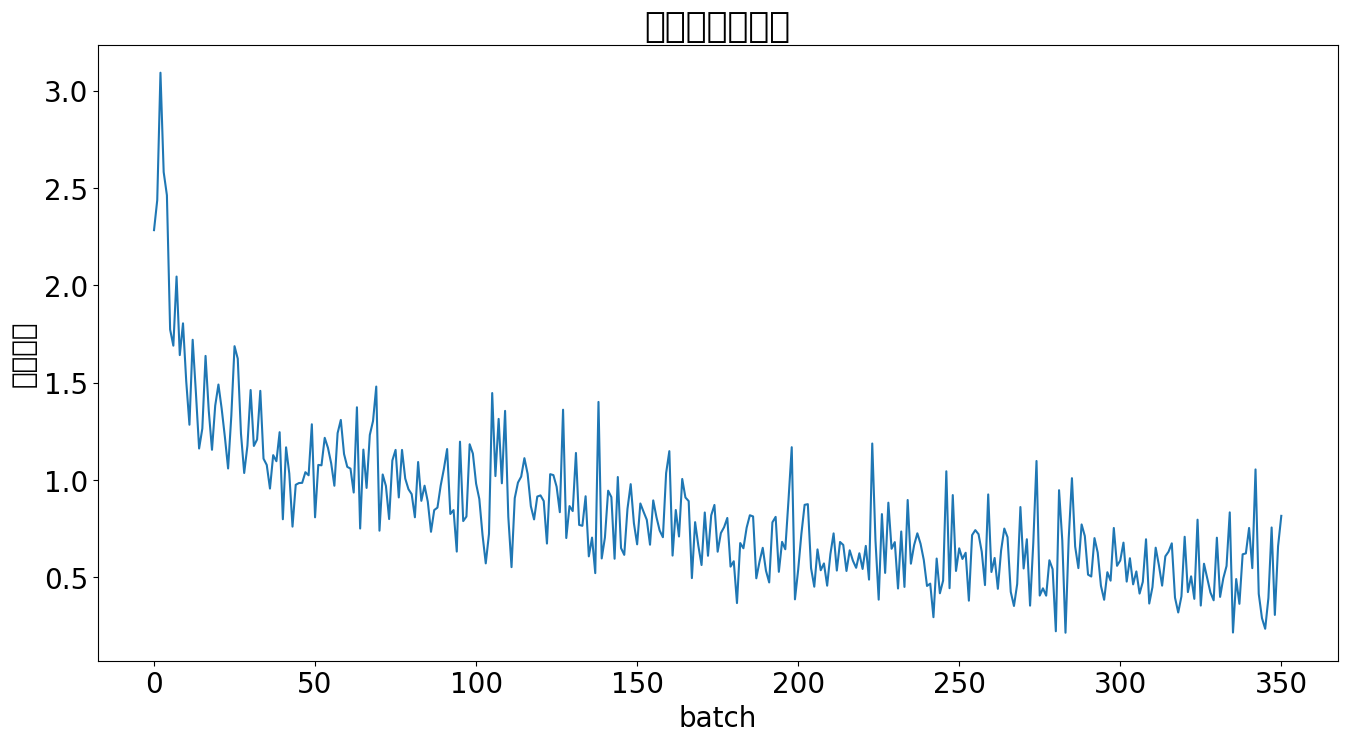

In [ ]:
plt.figure(figsize=(16, 8))

x = df_train['batch']
y = df_train['train_loss']

plt.plot(x, y, label='训练集')

plt.tick_params(labelsize=20)
plt.xlabel('batch', fontsize=20)
plt.ylabel('损失函数', fontsize=20)
plt.title('训练集损失函数', fontsize=25)
# plt.savefig('图表/训练集损失函数.pdf', dpi=120, bbox_inches='tight')

plt.show()

#预测

In [ ]:
!pip install numpy pandas matplotlib requests tqdm opencv-python pillow
!pip3 install torch torchvision torchaudio
!pip install mmcv-full
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 607.9/607.9 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 13.4 MB/s eta 0:00:00
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 417, in run
    _, build_failures = build(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_builder.py", line 320, in build
    wheel_file = _build_one(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_builder.py", line 194, in _build_one
    wheel_path = _build_one_inside_env(
  File "/usr/local/lib/python3.

In [ ]:
import os

import torch
import torchvision
import torch.nn.functional as F

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

idx_to_labels = np.load('idx_to_labels.npy', allow_pickle=True).item()
model = torch.load('/content/checkpoint/best-0.889.pth')
model = model.eval().to(device)

from torchvision import transforms
# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
                                    ])

FlangNut        87.6143
HornNuts        5.7452
EccentricNuts   3.4610
BarrelNut       1.8893
SlottedNut      0.9582
M8Nut           0.1095
M5Nut           0.1088
M6Nut           0.0574
M3Nut           0.0483
M4Nut           0.0078


(-0.5, 1199.5, 1199.5, -0.5)

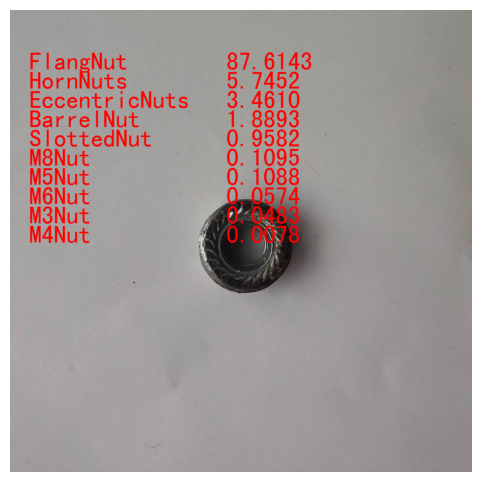

In [ ]:
from PIL import Image
from PIL import Image, ImageFont, ImageDraw

img_path = '/content/drive/MyDrive/new_data/FlangNut/IMG_20240201_095505.jpg'



img_pil = Image.open(img_path)
input_img = test_transform(img_pil) # 预处理
input_img = input_img.unsqueeze(0).to(device)
# 执行前向预测，得到所有类别的 logit 预测分数
pred_logits = model(input_img)
pred_softmax = F.softmax(pred_logits, dim=1)

n = 10
top_n = torch.topk(pred_softmax, n) # 取置信度最大的 n 个结果
pred_ids = top_n[1].cpu().detach().numpy().squeeze() # 解析出类别
confs = top_n[0].cpu().detach().numpy().squeeze() # 解析出置信度

draw = ImageDraw.Draw(img_pil)
font = ImageFont.truetype('SimHei.ttf', 64)

for i in range(n):
    class_name = idx_to_labels[pred_ids[i]] # 获取类别名称
    confidence = confs[i] * 100 # 获取置信度
    text = '{:<15} {:>.4f}'.format(class_name, confidence) # 保留 4 位小数
    print(text)

    # 文字坐标，中文字符串，字体，rgba颜色
    draw.text((50, 100 + 50 * i), text, font=font, fill=(255, 0, 0, 1))


fig = plt.figure(figsize=(18,6))

# 绘制左图-预测图
ax1 = plt.subplot(1,2,1)
ax1.imshow(img_pil)
ax1.axis('off')